#### Importar lo necesario

In [ ]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt


#### configuramos el `device` acorde al device disponible




In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


#**MNIST data base**
# Ejemplo de red neuronal de convolución (CNN)

Vamos a usar la base de datos de MNIST ([ver fuente](http://yann.lecun.com/exdb/mnist/)) para entrenar una CNN que identifique números escritos a mano.

Para esto necesitamos:


1.   Cargar la base de datos.
2.   Ver que la base de datos esté ok.
3.   Construir nuestra CNN.
4. Ver que las dimensiones de la red sean consistentes.
4.   Definir funciones necesarias (de entrenamiento, de costo, etc.).
5. Entrenar la red.
6. Ver que funcione.
7. Visualizar el kernel.
8. Visualizar las activaciones.
9.  Ejercicio nro 1.




## 1. Cargar base de datos

In [ ]:
import pickle

X_test = torch.Tensor(np.resize(np.array(pickle.load( open( "/content/test.pkl", "rb" ) )), (7000, 1, 28, 28)))
y_test = torch.Tensor(np.array(pickle.load( open( "/content/test_label.pkl", "rb" ) )))
y_test = y_test.type(torch.LongTensor)
X_train = torch.Tensor(np.resize(np.array(pickle.load( open( "/content/train.pkl", "rb" ) )), (56000, 1, 28, 28)))
y_train = torch.Tensor(np.array(pickle.load( open( "/content/train_label.pkl", "rb" ))) )
y_train = y_train.type(torch.LongTensor)
X_val = torch.Tensor(np.resize(np.array(pickle.load( open( "/content/val.pkl", "rb" ) )), (7000, 1, 28, 28)))
y_val = torch.Tensor(np.array(pickle.load( open( "/content/val_label.pkl", "rb" ))) )
y_val = y_val.type(torch.LongTensor)
print('X_train: ',X_train.shape, ' y_train: ',y_train.shape)
print('X_test: ',X_test.shape, ' y_test: ',y_test.shape)
print('X_val: ',X_val.shape, ' y_val: ',y_val.shape)

from torch.utils.data import DataLoader, TensorDataset

std = np.std(np.array(pickle.load( open( "/content/test.pkl", "rb" ) )))
mean = np.mean(np.array(pickle.load( open( "/content/test.pkl", "rb" ) )))

transform=torchvision.transforms.Compose([torchvision.transforms.Normalize(mean,std)])
X_train_t = transform(X_train)
X_test_t = transform(X_test)
X_val_t = transform(X_val)
train_dataset = TensorDataset(X_train_t,y_train) 
test_dataset = TensorDataset(X_test_t,y_test) 
val_dataset = TensorDataset(X_val_t,y_val)

dataloader = {
    'train': DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True),
    'test': DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)
}

X_train:  torch.Size([56000, 1, 28, 28])  y_train:  torch.Size([56000])
X_test:  torch.Size([7000, 1, 28, 28])  y_test:  torch.Size([7000])
X_val:  torch.Size([7000, 1, 28, 28])  y_val:  torch.Size([7000])


## 2. Ver que la base de datos esté OK

In [ ]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


Tamaño del batch de feature (input / imagen): torch.Size([128, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([128])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


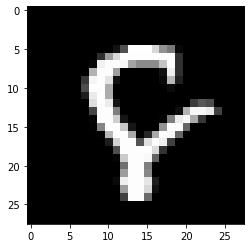

Label: 8


In [ ]:
# Ver imagen and label del dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 3. Construyo mis CNN

In [ ]:
# defino primero un "bloque" de una capa CNN
# construido con los bloques funcionales vistos en clase
#
# (hiper)parámetros a pasar a la función:
#   c_in:   canales (kernels) de entrada
#   c_out:  canales (kernels) de salida
#   k:      tamaño del kernel kxk
#   p:      tamaño del padding de la convolución
#   s:      stride de la convolución
#   pk:     tamaño del kernel del pooling
#   ps:     stride de la pooling
#   pp:     padding en la pooling
#
#   la función pooling se elige directamente dentro del bloque!

def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )


# ahora SI construyo mi red... usando la clase CNN de pytorch
# revisar muy bien las dimensiones a emplear en cada capa y
# tener presente la reducción de las dimensiones.
#
# en la útlima capa fully conected 'fc', hacer bien el cálculo final del
# tamaño del array que se obtiene siguiendo la formula vista en la teoria
# tanto para la capa conv como para la capa pooling.
#
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv1_out = None #14 x 14
    self.conv2 = block(64, 128) 
    self.conv2_out = None   # 7 x 7
    self.conv3 = block(128, 254) 
    self.conv3_out = None  # 3 x 3
    self.conv4 = block(254, 1568) 
    self.conv4_out = None  # 1 x 1
    self.fc = torch.nn.Linear(1568*2*2, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    self.i=0
    for layer in self.children():
        self.i = self.i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', self.i)
    
    # Me fijo en el número de parámetros entrenables
    self.pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', self.pytorch_total_params)

  def validar_dim(self):
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)


  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y
  

In [ ]:
model = CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 254, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(254, 1568, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=6272, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  6
Número t

## 4. Veamos que las dimensiones sean consistentes.

In [ ]:
from torch.nn.modules.container import ModuleList
model.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 64, 14, 14])
Tamaño salida conv2:  torch.Size([1, 128, 7, 7])
Tamaño salida conv3:  torch.Size([1, 254, 4, 4])
Tamaño salida conv4:  torch.Size([1, 1568, 2, 2])
Tamaño imagen vectorizada:  torch.Size([1, 6272])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


## 5. Armo las funciones necesarias

In [ ]:
from tqdm import tqdm # <- para graficar la barra de avance

def fit(model, dataloader, epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
    acc_final = np.mean(val_acc)
    
    score = (10*acc_final*model.i)/(np.log(model.pytorch_total_params)*epochs)
    print("score = ", score)
  

## 6. Entreno la red

In [ ]:
epochs = 1
fit(model, dataloader, epochs)

val_loss 0.07325 val_acc 0.97765: 100%|██████████| 55/55 [00:35<00:00,  1.57it/s]

Epoch 1/1 loss 0.31685 val_loss 0.07325 acc 0.91007 val_acc 0.97765
score =  3.8576559306006866


Otra versión

In [ ]:
# defino primero un "bloque" de una capa CNN
# construido con los bloques funcionales vistos en clase
#
# (hiper)parámetros a pasar a la función:
#   c_in:   canales (kernels) de entrada
#   c_out:  canales (kernels) de salida
#   k:      tamaño del kernel kxk
#   p:      tamaño del padding de la convolución
#   s:      stride de la convolución
#   pk:     tamaño del kernel del pooling
#   ps:     stride de la pooling
#   pp:     padding en la pooling
#
#   la función pooling se elige directamente dentro del bloque!

def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )


# ahora SI construyo mi red... usando la clase CNN de pytorch
# revisar muy bien las dimensiones a emplear en cada capa y
# tener presente la reducción de las dimensiones.
#
# en la útlima capa fully conected 'fc', hacer bien el cálculo final del
# tamaño del array que se obtiene siguiendo la formula vista en la teoria
# tanto para la capa conv como para la capa pooling.
#
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv1_out = None #14 x 14
    self.conv2 = block(64, 254) 
    self.conv2_out = None   # 7 x 7
    self.conv3 = block(254, 392) 
    self.conv3_out = None  # 3 x 3
    #self.conv4 = block(512, 1568) 
    #self.conv4_out = None  # 1 x 1
    self.fc = torch.nn.Linear(392*4*4, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    self.i=0
    for layer in self.children():
        self.i = self.i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', self.i)
    
    # Me fijo en el número de parámetros entrenables
    self.pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', self.pytorch_total_params)

  def validar_dim(self):
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

   # x = self.conv4(x)
   # print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)


  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
   # self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y
  

In [ ]:
model = CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 254, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(254, 392, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=6272, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  1106432


In [ ]:
from torch.nn.modules.container import ModuleList
model.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 64, 14, 14])
Tamaño salida conv2:  torch.Size([1, 254, 7, 7])
Tamaño salida conv3:  torch.Size([1, 392, 4, 4])
Tamaño imagen vectorizada:  torch.Size([1, 6272])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


In [ ]:
from tqdm import tqdm # <- para graficar la barra de avance

def fit(model, dataloader, epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
    acc_final = np.mean(val_acc)
    
    score = (10*acc_final*model.i)/(np.log(model.pytorch_total_params)*epochs)
    print("score = ", score)
  

In [ ]:
epochs = 1
fit(model, dataloader, epochs)

val_loss 0.08535 val_acc 0.97253: 100%|██████████| 55/55 [00:29<00:00,  1.87it/s]

Epoch 1/1 loss 0.31395 val_loss 0.08535 acc 0.91658 val_acc 0.97253
score =  3.4941365407157


Otra versión

In [ ]:
# defino primero un "bloque" de una capa CNN
# construido con los bloques funcionales vistos en clase
#
# (hiper)parámetros a pasar a la función:
#   c_in:   canales (kernels) de entrada
#   c_out:  canales (kernels) de salida
#   k:      tamaño del kernel kxk
#   p:      tamaño del padding de la convolución
#   s:      stride de la convolución
#   pk:     tamaño del kernel del pooling
#   ps:     stride de la pooling
#   pp:     padding en la pooling
#
#   la función pooling se elige directamente dentro del bloque!

def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=4, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )


# ahora SI construyo mi red... usando la clase CNN de pytorch
# revisar muy bien las dimensiones a emplear en cada capa y
# tener presente la reducción de las dimensiones.
#
# en la útlima capa fully conected 'fc', hacer bien el cálculo final del
# tamaño del array que se obtiene siguiendo la formula vista en la teoria
# tanto para la capa conv como para la capa pooling.
#
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv1_out = None #8 x 8
    self.conv2 = block(64, 1568) 
    self.conv2_out = None   # 2 x 2
    #self.conv3 = block(254, 392) 
    #self.conv3_out = None  # 3 x 3
    #self.conv4 = block(512, 1568) 
    #self.conv4_out = None  # 1 x 1
    self.fc = torch.nn.Linear(1568*2*2, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    self.i=0
    for layer in self.children():
        self.i = self.i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', self.i)
    
    # Me fijo en el número de parámetros entrenables
    self.pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', self.pytorch_total_params)

  def validar_dim(self):
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

   # x = self.conv3(x)
   # print("Tamaño salida conv3: ", x.shape)

   # x = self.conv4(x)
   # print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)


  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
   # self.conv3_out = self.conv3(self.conv2_out)
   # self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv2_out.view(self.conv2_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y
  

In [ ]:
model = CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=4, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 1568, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=4, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=6272, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  4
Número total de parámetros a entrenar:  968106


In [ ]:
from torch.nn.modules.container import ModuleList
model.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 64, 7, 7])
Tamaño salida conv2:  torch.Size([1, 1568, 2, 2])
Tamaño imagen vectorizada:  torch.Size([1, 6272])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


In [ ]:
from tqdm import tqdm # <- para graficar la barra de avance

def fit(model, dataloader, epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
    acc_final = np.mean(val_acc)
    
    score = (10*acc_final*model.i)/(np.log(model.pytorch_total_params)*epochs)
    print("score = ", score)
  

In [ ]:
epochs = 1
fit(model, dataloader, epochs)

val_loss 0.15119 val_acc 0.96060: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]

Epoch 1/1 loss 0.48852 val_loss 0.15119 acc 0.88556 val_acc 0.96060
score =  2.787767555141407
